# Train smarter Naive Bayes model with labelled data

The running of this script creates new pickle object with Naive Bayes model. Periodically runs the notebook and replace the pickle file in object with a new one as it only gets better with more data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.naive_bayes import ComplementNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/vlado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('hn_topic_labelling.csv', header=None)
df.columns = ['index', 'text', 'naive_bayes_label', 'neural_net_label', 'checked_label']
df = df[['text', 'checked_label']]
df = df.dropna()
df.shape

(1118, 2)

In [4]:
df2 = pd.read_csv('long_articles.csv', header=None)
df2.columns = ['index', 'text', 'naive_bayes_label', 'neural_net_label', 'checked_label']
df2 = df2[['text', 'checked_label']]
df2 = df2.dropna()
df2.shape

(288, 2)

In [5]:
df

,text,checked_label
0,"I don&#x27;t disagree. But, at the same time, ...",AI/Data Science
1,In math what you suggest is considered bad pra...,AI/Data Science
2,"Indeed, but is relevant? If you have a machine...",AI/Data Science
3,"&gt; I don&#x27;t think so, as you can embed a...",AI/Data Science
4,The last part is shocking to say the least. It...,AI/Data Science
...,...,...
1113,The regex is surely faster for the specific ca...,web/mobile
1114,Personally I&#x27;ve found that the value in t...,web/mobile
1115,There are some projects which I&#x27;ve migrat...,web/mobile
1116,&gt; &quot;The Tor network is an anonymous rel...,web/mobile


In [6]:
df_cut = df[df['text'].str.len() > 500]
df_cut

,text,checked_label
3,"&gt; I don&#x27;t think so, as you can embed a...",AI/Data Science
7,As a small company using one of the providers ...,AI/Data Science
12,It&#x27;s because people confuse Google&#x27;s...,AI/Data Science
20,You don&#x27;t seem to understand what I mean....,AI/Data Science
22,Some of my family and I have been enjoying pla...,AI/Data Science
...,...,...
1100,"I&#x27;ve got no experience with Datasette, bu...",web/mobile
1103,But I think the new policy changes allow Whats...,web/mobile
1109,I am using a third party service which would t...,web/mobile
1110,"Hi, I think a bit of context is needed to unde...",web/mobile


In [7]:
df2

,text,checked_label
0,My first thought was that too (After all Tesla...,AI/Data Science
1,"Hello HN,<p>I am entering a role which require...",AI/Data Science
2,Highway self-driving is not the computational ...,AI/Data Science
3,Because they can do it and because its current...,AI/Data Science
4,This whole discussion reminds me of work we di...,AI/Data Science
...,...,...
283,"Well, the ability to specify python version by...",web/mobile
284,Whether it&#x27;s an environmental improvement...,web/mobile
285,As a developer of an Electron app to me a comp...,web/mobile
286,You&#x27;re going to do great. Just steer the ...,web/mobile


In [8]:
df_for_nn = df_cut.append(df2)
df_for_nn

,text,checked_label
3,"&gt; I don&#x27;t think so, as you can embed a...",AI/Data Science
7,As a small company using one of the providers ...,AI/Data Science
12,It&#x27;s because people confuse Google&#x27;s...,AI/Data Science
20,You don&#x27;t seem to understand what I mean....,AI/Data Science
22,Some of my family and I have been enjoying pla...,AI/Data Science
...,...,...
283,"Well, the ability to specify python version by...",web/mobile
284,Whether it&#x27;s an environmental improvement...,web/mobile
285,As a developer of an Electron app to me a comp...,web/mobile
286,You&#x27;re going to do great. Just steer the ...,web/mobile


In [9]:
df_for_nn.to_csv('data_for_rnn.csv', index=False)

In [10]:
df = df.append(df2)
df['checked_label'] = df['checked_label'].replace({'web/moble': 'web/mobile'})
df

,text,checked_label
0,"I don&#x27;t disagree. But, at the same time, ...",AI/Data Science
1,In math what you suggest is considered bad pra...,AI/Data Science
2,"Indeed, but is relevant? If you have a machine...",AI/Data Science
3,"&gt; I don&#x27;t think so, as you can embed a...",AI/Data Science
4,The last part is shocking to say the least. It...,AI/Data Science
...,...,...
283,"Well, the ability to specify python version by...",web/mobile
284,Whether it&#x27;s an environmental improvement...,web/mobile
285,As a developer of an Electron app to me a comp...,web/mobile
286,You&#x27;re going to do great. Just steer the ...,web/mobile


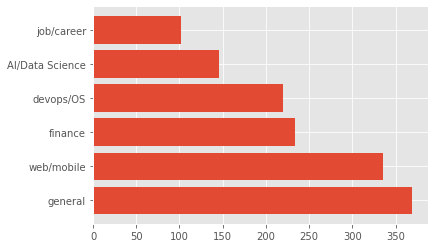

In [11]:
plt.figure(figsize=[6,4])
plt.barh(df['checked_label'].value_counts().index, df['checked_label'].value_counts());

We are going to have to clean the junk out of the text.

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\d', '', text)
    text = text.strip(' ')
    return text

def remove_stopwords(row):
    final_row = [w for w in row.split(' ') if w not in stopwords.words('english')]
    final_row = ' '.join(final_row)
    return final_row


In [13]:
df['text'] = df['text'].map(clean_text)
df['text'] = df['text'].map(remove_stopwords)

In [14]:
df

,text,checked_label
0,x disagree time especially macro sense theoret...,AI/Data Science
1,math suggest considered bad practice also stro...,AI/Data Science
2,indeed relevant machine average memory install...,AI/Data Science
3,gt x think embed allmost math concept real wor...,AI/Data Science
4,last part shocking say least hard patient imag...,AI/Data Science
...,...,...
283,well ability specify python version module wou...,web/mobile
284,whether x environmental improvement depends em...,web/mobile
285,developer electron app competitor framework x ...,web/mobile
286,x going great steer ship back direction elevat...,web/mobile


## Tf-IDF

Here we use Tf IDf which is a method based mainly on the frequency of the words. It's very good with the simpler models that we will be creating  here. 

In [15]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(df['text'])

In [16]:
x_train = x_train.toarray()

In [17]:
df['checked_label'].unique()

array(['AI/Data Science', 'devops/OS', 'finance', 'general', 'job/career',
       'web/mobile'], dtype=object)

In [18]:
df['checked_label'] = df['checked_label'].map({'AI/Data Science': 0, 'devops/OS': 1, 'finance': 2, 
                                               'general': 3, 'job/career': 4,  'web/mobile': 5})
y_train = df['checked_label'] 

In [19]:
x_train.shape, y_train.shape

((1406, 11232), (1406,))

## Split into train - test 


In [20]:
# oversample = RandomOverSampler({0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250})
# x_train, y_train = oversample.fit_resample(x_train, y_train)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [22]:
x_train.shape, y_train.shape

((1124, 11232), (1124,))

In [23]:
x_test.shape, y_test.shape

((282, 11232), (282,))

## Naive Bayes

Very good with text data, sparse matrices and tf-idf.

In [24]:
nb = ComplementNB()

In [25]:
nb.fit(x_train, y_train)

ComplementNB()

In [26]:
preds = nb.predict(x_test)

In [27]:
def print_metrics(model, predictions):
    print(f'Train Accuracy: {model.score(x_train, y_train)}')
    print(f'Test Accuracy: {model.score(x_test, y_test)}')
    print(f'F1 score: {f1_score(predictions, y_test, average = "weighted")}')

In [28]:
print_metrics(nb, preds)

Train Accuracy: 0.9759786476868327
Test Accuracy: 0.6702127659574468
F1 score: 0.6741557486953518


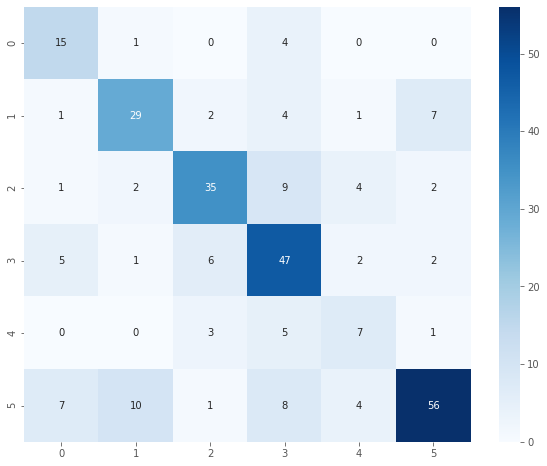

In [29]:
def show_confusion_matrix(predictions):
    conf_matrix = confusion_matrix(predictions, y_test)
    plt.figure(figsize=[10,8])
    sns.heatmap(conf_matrix, annot = True, fmt ='d',cmap = 'Blues');

show_confusion_matrix(preds)

## Save model

Let's create a pipeline that will ease the model when serves in production.

In [30]:
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])
pipe.fit(df['text'] , df['checked_label'] )

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])

In [31]:
def test_with_random_text(txt):
    txt = clean_text(txt)
    txt = remove_stopwords(txt)
    pred = pipe.predict([txt])
    return pred

In [32]:
pred = test_with_random_text('Windows is the worst OS there is. I hope people will soon see the excelence of Linux')
pred

array([1])

In [33]:
pred = test_with_random_text('This is all about politics.This is not in our labels so it should be general')
pred

array([3])

In [34]:
pred = test_with_random_text('AWS is the first cloud provider that i can think of. The label should be one')
pred

array([1])

In [35]:
import pickle
save_classifier = open("nb_topic_classifier.pickle","wb")
pickle.dump(pipe, save_classifier)
save_classifier.close()